<a href="https://colab.research.google.com/github/SamudralaAjaykumarrr/ML-Model-Validation-Framework/blob/main/ML_Model_Validation_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Cell 1 — Setup
import os
import json
import joblib
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# reproducibility
RSEED = 42
np.random.seed(RSEED)

# output folder
OUTDIR = "/content/model_validation_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# expected paths (from Project A conventions)
MODEL_PATH = "/content/openai_prompt_regression_outputs/openai_prompt_regression_model.pkl"
DATASET_PATH = "/content/openai_prompt_regression_outputs/prompt_regression_dataset.csv"

print("Setup complete. Output folder:", OUTDIR)


Setup complete. Output folder: /content/model_validation_outputs


In [4]:
# Cell 2 — Load dataset if available; otherwise generate a synthetic dataset and save it
def generate_synthetic_prompt_dataset(n=800, seed=RSEED):
    np.random.seed(seed)
    df = pd.DataFrame({
        "prompt_length": np.random.randint(5, 120, n),
        "num_keywords": np.random.randint(0, 12, n),
        "temperature": np.round(np.random.uniform(0.05, 1.0, n), 3),
        "response_length": np.random.randint(10, 400, n),
        "avg_word_complexity": np.round(np.random.uniform(1.0, 3.0, n), 3)
    })
    df["performance_score"] = (
          40
        + 0.25 * df["prompt_length"]
        + 1.8  * df["num_keywords"]
        - 30   * df["temperature"]
        + 0.12 * df["response_length"]
        - 2.5  * (df["avg_word_complexity"] - 1.5)**2
        + np.random.normal(0, 4.0, n)
    )
    df["performance_score"] = df["performance_score"].clip(0, 100).round(3)
    return df

# Try loading dataset
if os.path.exists(DATASET_PATH):
    try:
        df = pd.read_csv(DATASET_PATH)
        print("Loaded dataset from:", DATASET_PATH, "shape:", df.shape)
    except Exception as e:
        print("Failed to load existing dataset. Generating synthetic dataset. Error:", e)
        df = generate_synthetic_prompt_dataset()
        df.to_csv(os.path.join(OUTDIR, "prompt_regression_dataset_generated.csv"), index=False)
        print("Synthetic dataset saved to:", os.path.join(OUTDIR, "prompt_regression_dataset_generated.csv"))
else:
    print("Dataset not found at expected path. Generating synthetic dataset.")
    df = generate_synthetic_prompt_dataset()
    df.to_csv(os.path.join(OUTDIR, "prompt_regression_dataset_generated.csv"), index=False)
    print("Synthetic dataset saved to:", os.path.join(OUTDIR, "prompt_regression_dataset_generated.csv"))

display(df.head())
print("\nColumns:", df.columns.tolist())


Dataset not found at expected path. Generating synthetic dataset.
Synthetic dataset saved to: /content/model_validation_outputs/prompt_regression_dataset_generated.csv


,prompt_length,num_keywords,temperature,response_length,avg_word_complexity,performance_score
0,107,9,0.563,129,2.015,75.708
1,56,9,0.204,138,2.748,79.505
2,97,2,0.849,139,1.987,56.455
3,19,6,0.854,69,2.405,37.216
4,111,2,0.957,57,2.986,45.136



Columns: ['prompt_length', 'num_keywords', 'temperature', 'response_length', 'avg_word_complexity', 'performance_score']


In [5]:
# Cell 3 — Load model if available; otherwise train a new LinearRegression model and save it
FEATURES = ["prompt_length","num_keywords","temperature","response_length","avg_word_complexity"]
TARGET = "performance_score"

model_loaded = False
if os.path.exists(MODEL_PATH):
    try:
        model = joblib.load(MODEL_PATH)
        model_loaded = True
        print("Loaded model from:", MODEL_PATH)
    except Exception as e:
        print("Failed to load model at expected path. Will train a new model. Error:", e)

if not model_loaded:
    # Train/test split and train a simple model to use for validation
    print("Training a new LinearRegression model (fallback).")
    X = df[FEATURES]
    y = df[TARGET]
    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, random_state=RSEED)
    model = LinearRegression()
    model.fit(X_train, y_train)
    # save the trained model to OUTDIR (so you can inspect and upload)
    auto_model_path = os.path.join(OUTDIR, "openai_prompt_regression_model_trained_here.pkl")
    joblib.dump(model, auto_model_path)
    print("Fallback model trained and saved to:", auto_model_path)

# Quick sanity predict to ensure model works
try:
    sample_pred = model.predict(df[FEATURES].iloc[:5])
    print("Model predicts sample values (OK).")
except Exception as e:
    raise RuntimeError("Model loaded/trained but prediction failed. Error: " + str(e))


Training a new LinearRegression model (fallback).
Fallback model trained and saved to: /content/model_validation_outputs/openai_prompt_regression_model_trained_here.pkl
Model predicts sample values (OK).


In [6]:
# Cell 4 — Run validation on full dataset (or optionally on a holdout)
X = df[FEATURES]
y = df[TARGET]

# Use the entire dataset for validation here (production use would use holdout)
y_pred = model.predict(X)

mae  = mean_absolute_error(y, y_pred)
rmse = sqrt(mean_squared_error(y, y_pred))
r2   = r2_score(y, y_pred)

validation_report = {
    "MAE": float(mae),
    "RMSE": float(rmse),
    "R2": float(r2),
    "n_rows": int(len(df))
}

# Save predictions + input ranges + report
pred_df = df[FEATURES].copy()
pred_df["true"] = y
pred_df["pred"] = np.round(y_pred, 3)
pred_path = os.path.join(OUTDIR, "predictions_full.csv")
pred_df.to_csv(pred_path, index=False)

# input ranges (sanity)
input_ranges = {c: {"min": float(df[c].min()), "max": float(df[c].max())} for c in FEATURES}
with open(os.path.join(OUTDIR, "input_ranges.json"), "w") as f:
    json.dump(input_ranges, f, indent=2)

with open(os.path.join(OUTDIR, "validation_report.json"), "w") as f:
    json.dump(validation_report, f, indent=2)

print("Validation complete. Metrics:", validation_report)
print("Saved predictions to:", pred_path)
print("Saved input ranges and validation report in:", OUTDIR)


Validation complete. Metrics: {'MAE': 3.57940297872864, 'RMSE': 4.633895483828296, 'R2': 0.9353394877343137, 'n_rows': 800}
Saved predictions to: /content/model_validation_outputs/predictions_full.csv
Saved input ranges and validation report in: /content/model_validation_outputs


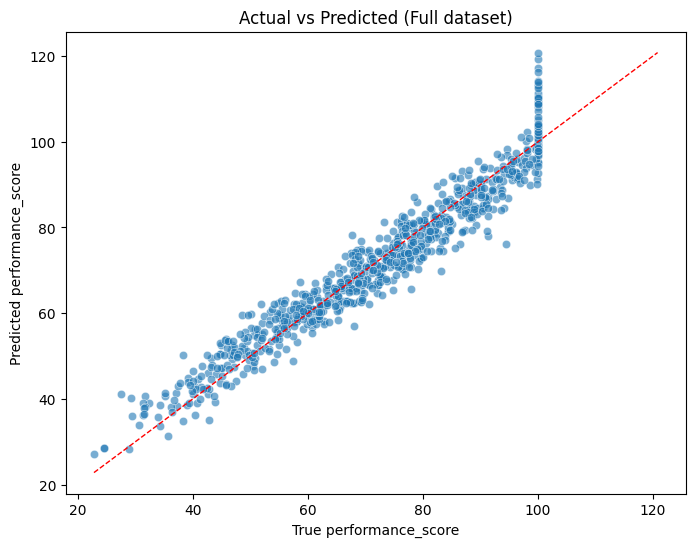

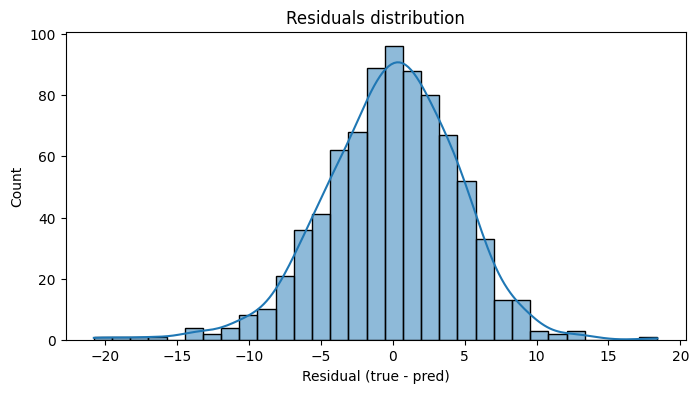

Sanity checks done. Flags saved to: /content/model_validation_outputs/validation_flags.json


,pred_var,max_abs_error,high_error_rows_sample
0,310.635263,20.805,"{'prompt_length': 97, 'num_keywords': 10, 'tem..."
1,310.635263,20.805,"{'prompt_length': 119, 'num_keywords': 10, 'te..."
2,310.635263,20.805,"{'prompt_length': 108, 'num_keywords': 6, 'tem..."


In [7]:
# Cell 5 — Plots and checks
plt.figure(figsize=(8,6))
sns.scatterplot(x=pred_df["true"], y=pred_df["pred"], alpha=0.6)
mn, mx = min(pred_df["true"].min(), pred_df["pred"].min()), max(pred_df["true"].max(), pred_df["pred"].max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel("True performance_score")
plt.ylabel("Predicted performance_score")
plt.title("Actual vs Predicted (Full dataset)")
plt.show()

# Residuals
residuals = pred_df["true"] - pred_df["pred"]
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution")
plt.xlabel("Residual (true - pred)")
plt.show()

# Quick flagging: zero variance predictions or extreme errors
pred_var = float(np.var(pred_df["pred"]))
max_abs_error = float(np.max(np.abs(pred_df["true"] - pred_df["pred"])))
flags = {
    "pred_var": pred_var,
    "max_abs_error": max_abs_error,
    "high_error_rows_sample": pred_df.iloc[(pred_df["true"] - pred_df["pred"]).abs().sort_values(ascending=False).head(3).index].to_dict(orient="records")
}
with open(os.path.join(OUTDIR, "validation_flags.json"), "w") as f:
    json.dump(flags, f, indent=2)

print("Sanity checks done. Flags saved to:", os.path.join(OUTDIR, "validation_flags.json"))
display(pd.DataFrame(flags))


In [8]:
# Cell 6 — Final summary and list outputs
print("=== Validation summary ===")
print(json.dumps(validation_report, indent=2))
print("\nOutputs written to:", OUTDIR)
!ls -la {OUTDIR}

# Provide browser download links (Colab will prompt)
from google.colab import files
files_to_offer = [
    os.path.join(OUTDIR, "validation_report.json"),
    os.path.join(OUTDIR, "predictions_full.csv"),
    os.path.join(OUTIR := OUTDIR, "input_ranges.json"),
    os.path.join(OUTDIR, "validation_flags.json")
]
# Only attempt downloads for files that exist
for p in files_to_offer:
    if os.path.exists(p):
        print("Offering download:", p)
        files.download(p)
    else:
        print("Missing (not downloaded):", p)

print("\nDone — everything ran successfully. Upload the files in /content/model_validation_outputs to your GitHub repo.")


=== Validation summary ===
{
  "MAE": 3.57940297872864,
  "RMSE": 4.633895483828296,
  "R2": 0.9353394877343137,
  "n_rows": 800
}

Outputs written to: /content/model_validation_outputs
total 76
drwxr-xr-x 2 root root  4096 Nov 20 12:37 .
drwxr-xr-x 1 root root  4096 Nov 20 12:33 ..
-rw-r--r-- 1 root root   303 Nov 20 12:37 input_ranges.json
-rw-r--r-- 1 root root   945 Nov 20 12:37 openai_prompt_regression_model_trained_here.pkl
-rw-r--r-- 1 root root 27784 Nov 20 12:37 predictions_full.csv
-rw-r--r-- 1 root root 22232 Nov 20 12:36 prompt_regression_dataset_generated.csv
-rw-r--r-- 1 root root   718 Nov 20 12:37 validation_flags.json
-rw-r--r-- 1 root root   103 Nov 20 12:37 validation_report.json
Offering download: /content/model_validation_outputs/validation_report.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Offering download: /content/model_validation_outputs/predictions_full.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Offering download: /content/model_validation_outputs/input_ranges.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Offering download: /content/model_validation_outputs/validation_flags.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Done — everything ran successfully. Upload the files in /content/model_validation_outputs to your GitHub repo.
